In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PySpark setup

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [202]:
# !wget https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [201]:
# !tar xzvf spark-3.5.0-bin-hadoop3.tgz

In [5]:
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [7]:
import findspark
findspark.init()

In [8]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, when
import pandas as pd

In [9]:
sc = pyspark.SparkContext('local[*]')
spark = SparkSession(sc)
spark

# Upload data

In [11]:
%cd drive/MyDrive/MMDB

/content/drive/MyDrive/MMDB


In [139]:
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
# !tar xzvf sample.tgz

In [141]:
import json

with open('sample.jsonl', 'r') as fin:
    samples = list(map(json.loads, fin.readlines()))

In [142]:
# df = spark.read.option("multiline","true").json('/content/changes_enwiki_1000_sec.json')

In [143]:
df = spark.createDataFrame(samples)

In [144]:
# df.columns

In [145]:
df.show(5)

+--------------------+-----+--------------------+----------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+--------------------+------+
|             $schema|  bot|             comment|        id|              length|                meta|minor|namespace|          notify_url|       parsedcomment|            revision|     server_name|server_script_path|          server_url| timestamp|               title|           title_url|type|                user|  wiki|
+--------------------+-----+--------------------+----------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+--------------------+------+
|/mediawiki/recent...|fal

In [146]:
df.count()

17625

# Describe the distribution of edits per users and bots

In [147]:
df_bot_distr = df.select('user', 'bot').toPandas().drop_duplicates()

In [148]:
df_bot_distr['bot'].value_counts()

False    3156
True       51
Name: bot, dtype: int64

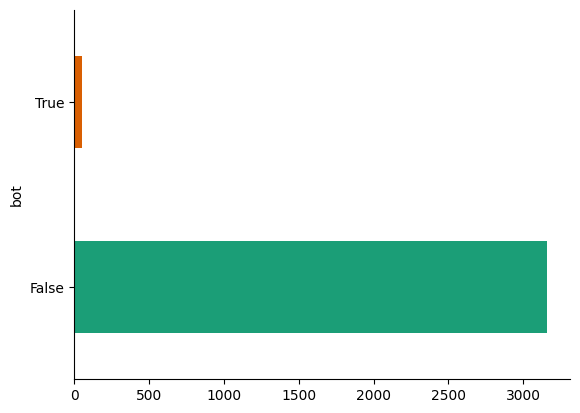

In [149]:
from matplotlib import pyplot as plt
import seaborn as sns
df_bot_distr.groupby('bot').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [150]:
df_users = df.filter(df.bot == 'false').groupBy('user').count().toPandas()

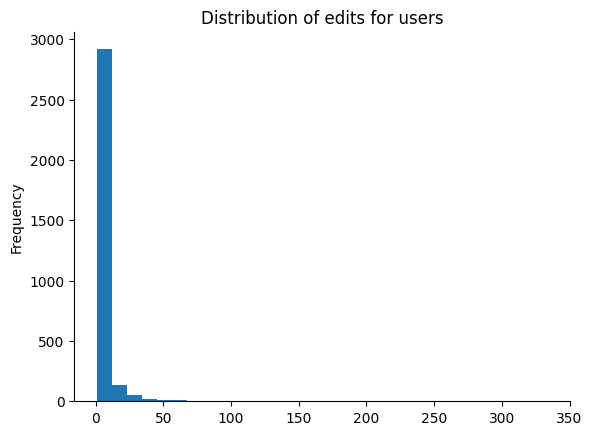

In [151]:
from matplotlib import pyplot as plt
df_users['count'].plot(kind='hist', bins=30, title='Distribution of edits for users')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [152]:
df_bots = df.filter(df.bot == 'true').groupBy('user').count().toPandas()

In [153]:
df_bots[:10]

,user,count
0,FACBot,8
1,Citation bot,117
2,SineBot,2
3,LivingBot,3
4,B-bot,2
5,Community Tech bot,2
6,HBC AIV helperbot5,29
7,ClueBot III,25
8,SDZeroBot,13
9,JJMC89 bot III,218


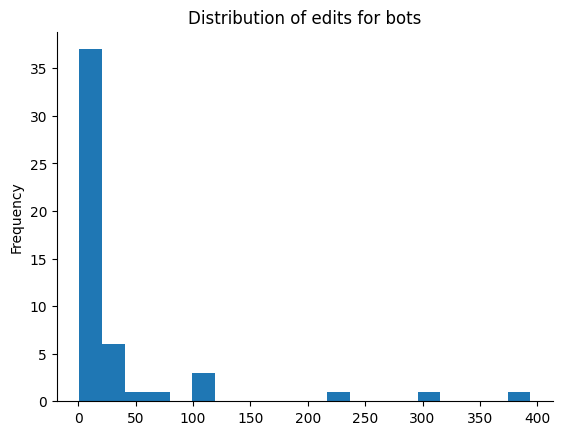

In [154]:
from matplotlib import pyplot as plt
df_bots['count'].plot(kind='hist', bins=20, title='Distribution of edits for bots')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train bot detection model

In [155]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# the average length of all edits per user as a feature
@udf(IntegerType())
def diff_length(length):
  old = length['old']
  new = length['new']
  return abs(new - old)

In [156]:
df = df.withColumn("length_difference", diff_length(df["length"]))

In [157]:
df = df.select('bot', 'length_difference', 'user')

In [158]:
from pyspark.sql.functions import count, mean, first

grouped_df = df.groupBy("user").agg(
    count("user").alias("count"),
    mean("length_difference").alias("mean_length_difference"),
    first("bot").alias("bot")
)

In [159]:
grouped_df.show(5)

+-------------+-----+----------------------+-----+
|         user|count|mean_length_difference|  bot|
+-------------+-----+----------------------+-----+
| 87.1.186.178|    5|                   4.2|false|
|  ThatOneWolf|   22|     557.4090909090909|false|
|   JackkBrown|  110|    18.136363636363637|false|
|      Wes3803|   11|     84.81818181818181|false|
|31.221.89.146|    8|               501.375|false|
+-------------+-----+----------------------+-----+
only showing top 5 rows



In [160]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

assembler = VectorAssembler(
  inputCols=["count", 'mean_length_difference'], outputCol="features"
)

assembled = assembler.transform(grouped_df)

In [161]:
assembled = assembled.withColumnRenamed("bot", "label").select('features', 'label', 'user')
assembled = assembled.withColumn('label', when(assembled.label, 1.0).otherwise(0.0))

In [162]:
assembled.show(5)

+--------------------+-----+-------------+
|            features|label|         user|
+--------------------+-----+-------------+
|           [5.0,4.2]|  0.0| 87.1.186.178|
|[22.0,557.4090909...|  0.0|  ThatOneWolf|
|[110.0,18.1363636...|  0.0|   JackkBrown|
|[11.0,84.81818181...|  0.0|      Wes3803|
|       [8.0,501.375]|  0.0|31.221.89.146|
+--------------------+-----+-------------+
only showing top 5 rows



## undersampling + updsampling
Upsamping: copy 3 times bots \
Undersampling: took a sample of users with the same amount as upsampled bots

In [177]:
df_pandas = assembled.toPandas()

In [178]:
df_bots_pandas = df_pandas[df_pandas['label']==1.0]
df_bots_pandas = pd.concat([df_bots_pandas, df_bots_pandas, df_bots_pandas])

df_users_pandas = df_pandas[df_pandas['label']==0.0].sample(n=len(df_bots_pandas))

df_pandas_new_sample = pd.concat([df_users_pandas, df_bots_pandas])
df_pandas_new_sample = df_pandas_new_sample.sample(frac = 1)

df_pandas_new_sample['label'].value_counts()

1.0    153
0.0    153
Name: label, dtype: int64

In [179]:
df_spark = spark.createDataFrame(df_pandas_new_sample)

In [180]:
df_spark.show(5)

+--------------------+-----+--------------+
|            features|label|          user|
+--------------------+-----+--------------+
|        [2.0,2505.5]|  1.0|    MajavahBot|
|[218.0,18.1376146...|  1.0|JJMC89 bot III|
|      [16.0,1015.75]|  1.0|       Legobot|
|           [1.0,1.0]|  0.0|142.126.75.111|
|[218.0,18.1376146...|  1.0|JJMC89 bot III|
+--------------------+-----+--------------+
only showing top 5 rows



## training

Note: \
train and test set - used for bot detection classifier; \
validation set - used for inference of the model and BloomFilter

In [181]:
train_df, test_df = df_spark.randomSplit(weights=[0.7,0.3], seed=100)
valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=100)

In [182]:
valid_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   28|
|  1.0|   19|
+-----+-----+



In [183]:
train_df.count(), test_df.count(), valid_df.count()

(210, 49, 47)

In [184]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [185]:
model = rf.fit(train_df)

In [196]:
predictions = model.transform(test_df)

In [197]:
predictions.show(5)

+---------+-----+-------------+--------------------+--------------------+----------+
| features|label|         user|       rawPrediction|         probability|prediction|
+---------+-----+-------------+--------------------+--------------------+----------+
|[1.0,0.0]|  0.0|     Mburrell|[3.80521235521235...|[0.38052123552123...|       1.0|
|[1.0,1.0]|  0.0|Movieknower59|[8.71756304799783...|[0.87175630479978...|       0.0|
|[1.0,5.0]|  0.0|       Noahp2|[8.71756304799783...|[0.87175630479978...|       0.0|
|[2.0,2.0]|  0.0|    Rlwrgh650|[8.64613447656926...|[0.86461344765692...|       0.0|
|[2.0,5.0]|  0.0|  HandsomeGum|[8.64613447656926...|[0.86461344765692...|       0.0|
+---------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



In [198]:
df_pred = predictions.select('features', 'prediction', 'label').toPandas()

In [199]:
df_pred['prediction'].value_counts()

0.0    26
1.0    23
Name: prediction, dtype: int64

In [200]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision bot-class:  0.7391304347826086
Precision user-class:  0.8076923076923077
Recall bot-class:  0.7727272727272727
Recall user-class:  0.7777777777777778
Weighted F1-score:  0.7758867068840114
